# 🛍️ Customer Segmentation Using RFM Analysis with Clustering


This project focuses on **customer segmentation** using the **RFM (Recency, Frequency, Monetary) model**, a powerful marketing technique used to identify and group customers based on their purchasing behavior. 

### 🔍 Project Objective
To segment customers into distinct groups based on:
- **Recency**: How recently a customer made a purchase
- **Frequency**: How often a customer makes a purchase
- **Monetary**: How much money a customer spends

By analyzing these three dimensions, we aim to:
- Understand customer value and engagement
- Identify loyal and high-spending customers
- Target marketing strategies more effectively
- Improve customer retention and business performance

The analysis is conducted using transactional data and will include data cleaning, RFM score calculation, segmentation, and visualization of the results.


In [732]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans , AgglomerativeClustering , DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator

## Read Dataset

In [734]:
df = pd.read_excel('Online Retail.xlsx')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [735]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Check NULL values

In [737]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [738]:
df.dropna(ignore_index=True , axis=0 , inplace=True)

### Check Duplicates and remove if exist

In [740]:
df.duplicated().sum()

5225

In [741]:
df.drop_duplicates(ignore_index=True , inplace=True)

In [742]:
df.drop(['StockCode' ,'Description'] , axis=1 , inplace=True)

In [743]:
df

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...
401599,581587,12,2011-12-09 12:50:00,0.85,12680.0,France
401600,581587,6,2011-12-09 12:50:00,2.10,12680.0,France
401601,581587,4,2011-12-09 12:50:00,4.15,12680.0,France
401602,581587,4,2011-12-09 12:50:00,4.15,12680.0,France


In [744]:
df['Country'].value_counts()

Country
United Kingdom          356728
Germany                   9480
France                    8475
EIRE                      7475
Spain                     2528
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1471
Australia                 1258
Norway                    1086
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     247
Unspecified                241
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45


### We will work on the data that includes the United States and make an RFM for it.

In [746]:
df = df[df['Country']=='United Kingdom'].copy()

In [747]:
df.drop(['Country'] ,axis=1 , inplace=True)

In [748]:
df.select_dtypes('number').describe()

,Quantity,UnitPrice,CustomerID
count,356728.000000,356728.000000,356728.000000
mean,11.198644,3.268255,15543.795284
std,264.998044,71.162330,1594.286219
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.950000,15513.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


### We will `drop` quantities less than or equal to 0 because these are quantities that have been returned.


In [750]:
df.drop(df[df['Quantity']<=0].index , axis=0 , inplace=True)

In [751]:
df.reset_index(inplace=True , drop=True)

### From `Quantity` and `UnitPrice` we will Extract Amount 

In [753]:
df['Amount'] = df['Quantity'] * df['UnitPrice']

### 📊 Grouping Transactions

We group the data by `CustomerID`, `InvoiceDate`, and `InvoiceNo` to calculate the **total invoice amount** per customer per transaction.


In [755]:
df = df.groupby(['CustomerID','InvoiceDate','InvoiceNo'])['Amount'].sum().reset_index()

In [756]:
df

,CustomerID,InvoiceDate,InvoiceNo,Amount
0,12346.0,2011-01-18 10:01:00,541431,77183.60
1,12747.0,2010-12-05 15:38:00,537215,358.56
2,12747.0,2010-12-13 10:41:00,538537,347.71
3,12747.0,2011-01-20 14:01:00,541677,303.04
4,12747.0,2011-03-01 14:53:00,545321,310.78
...,...,...,...,...
16671,18283.0,2011-11-30 12:59:00,579673,220.31
16672,18283.0,2011-12-06 12:02:00,580872,208.00
16673,18287.0,2011-05-22 10:39:00,554065,765.28
16674,18287.0,2011-10-12 10:23:00,570715,1001.32


### ⏳ Calculating Recency

We calculate the **recency** by subtracting each transaction date from today's date to find out how many days have passed since the last purchase.


In [758]:
df['InvoiceDate'].dt.year.max()

2011

In [759]:
today = datetime(np.max(df['InvoiceDate'].dt.year) , 12 , 31).date()

In [760]:
today

datetime.date(2011, 12, 31)

In [761]:
today - df['InvoiceDate'].dt.date

0        347 days, 0:00:00
1        391 days, 0:00:00
2        383 days, 0:00:00
3        345 days, 0:00:00
4        305 days, 0:00:00
               ...        
16671     31 days, 0:00:00
16672     25 days, 0:00:00
16673    223 days, 0:00:00
16674     80 days, 0:00:00
16675     64 days, 0:00:00
Name: InvoiceDate, Length: 16676, dtype: object

### 🧾 Counting Transactions per Customer

We count the number of invoices (`InvoiceNo`) for each `CustomerID` to measure **purchase frequency**.


In [763]:
df.groupby(['CustomerID'])['InvoiceNo'].count()

CustomerID
12346.0      1
12747.0     11
12748.0    211
12749.0      5
12820.0      4
          ... 
18280.0      1
18281.0      1
18282.0      2
18283.0     16
18287.0      3
Name: InvoiceNo, Length: 3921, dtype: int64

### 💰 Calculating Monetary Value

We calculate the **total amount spent** by each customer by summing the `Amount` for each `CustomerID`. This represents the **Monetary** value in the RFM model.


In [765]:
df.groupby(['CustomerID'])['Amount'].sum()

CustomerID
12346.0    77183.60
12747.0     4196.01
12748.0    33053.19
12749.0     4090.88
12820.0      942.34
             ...   
18280.0      180.60
18281.0       80.82
18282.0      178.05
18283.0     2045.53
18287.0     1837.28
Name: Amount, Length: 3921, dtype: float64

### 📦 Building the RFM Table

We create the **RFM table** by aggregating data for each `CustomerID`:

- **Recency**: Days since the customer's most recent purchase.
- **Frequency**: Total number of invoices (purchases).
- **Monetary**: Total amount spent.

This is done using the `.agg()` function, followed by renaming the columns to reflect the RFM metrics.


In [767]:
rfm = df.groupby(['CustomerID']).agg(
    {
        'InvoiceDate': lambda x : ((today - x.max().date()).days),
        'InvoiceNo' : lambda x : x.count(),
        'Amount' : lambda x : x.sum()
    }
).rename(mapper={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'Amount':'Montery'
},axis=1).reset_index()

In [768]:
rfm

,CustomerID,Recency,Frequency,Montery
0,12346.0,347,1,77183.60
1,12747.0,24,11,4196.01
2,12748.0,22,211,33053.19
3,12749.0,25,5,4090.88
4,12820.0,25,4,942.34
...,...,...,...,...
3916,18280.0,299,1,180.60
3917,18281.0,202,1,80.82
3918,18282.0,29,2,178.05
3919,18283.0,25,16,2045.53


In [769]:
df[df['CustomerID']==12749.0]['InvoiceDate'].max()

Timestamp('2011-12-06 09:56:00')

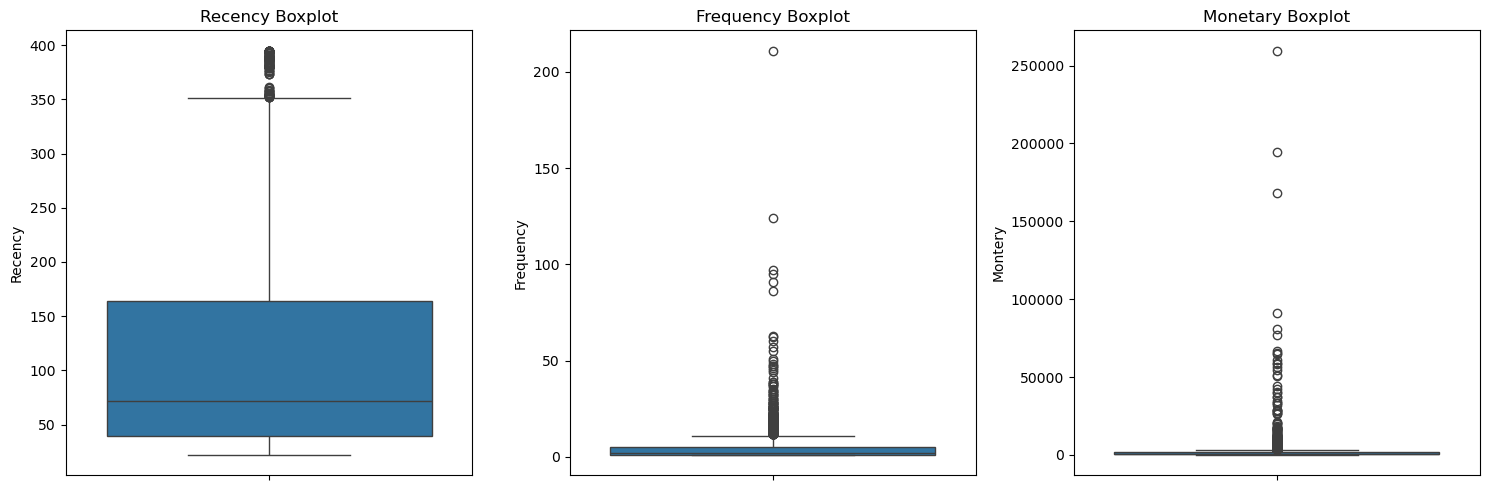

In [770]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=rfm['Recency'])
plt.title('Recency Boxplot')

plt.subplot(1, 3, 2)
sns.boxplot(y=rfm['Frequency'])
plt.title('Frequency Boxplot')

plt.subplot(1, 3, 3)
sns.boxplot(y=rfm['Montery'])
plt.title('Monetary Boxplot')

plt.tight_layout()
plt.show()


In [771]:
rfm.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Montery'], dtype='object')

### 🧮 Scoring RFM Metrics

We assign RFM **scores from 1 to 4** for each customer based on quartiles:

- **Recency Score (`r_score`)**: Lower recency (more recent purchase) gets a higher score.
- **Frequency Score (`f_score`)**: Customers who purchased more frequently get a higher score.
- **Monetary Score (`m_score`)**: Higher spenders receive higher scores.

We use `pd.qcut()` to divide each metric into 4 quantiles and assign the appropriate scores.


In [773]:
rfm['r_score'] = pd.qcut(rfm['Recency'] ,  4 , [4 , 3 ,2 ,1]).astype(int)
rfm['f_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm['m_score'] = pd.qcut(rfm['Montery'] ,  4 , [1, 2 ,3 ,4]).astype(int)

### 📊 Calculating the Overall RFM Score

We compute the **overall RFM score** by averaging the individual `r_score`, `f_score`, and `m_score` for each customer.  
This score helps rank customers based on their combined recency, frequency, and monetary behavior.


In [775]:
rfm['score'] = (rfm['r_score'] + rfm['f_score'] + rfm['m_score']) / 3

### 🏷️ Assigning Customer Segments

We segment customers into four groups — **Bronze, Silver, Gold, and Platinum** — based on their overall RFM score using `pd.qcut()`.  
This helps categorize customers by value, from lowest (Bronze) to highest (Platinum).


In [777]:
rfm['Segments'] = pd.qcut(rfm['score'] ,  4 , ['bronze' , 'silver' , 'gold' , 'platinum'])

In [778]:
rfm

,CustomerID,Recency,Frequency,Montery,r_score,f_score,m_score,score,Segments
0,12346.0,347,1,77183.60,1,1,4,2.000000,silver
1,12747.0,24,11,4196.01,4,4,4,4.000000,platinum
2,12748.0,22,211,33053.19,4,4,4,4.000000,platinum
3,12749.0,25,5,4090.88,4,3,4,3.666667,platinum
4,12820.0,25,4,942.34,4,3,3,3.333333,gold
...,...,...,...,...,...,...,...,...,...
3916,18280.0,299,1,180.60,1,2,1,1.333333,bronze
3917,18281.0,202,1,80.82,1,2,1,1.333333,bronze
3918,18282.0,29,2,178.05,4,3,1,2.666667,gold
3919,18283.0,25,16,2045.53,4,4,4,4.000000,platinum


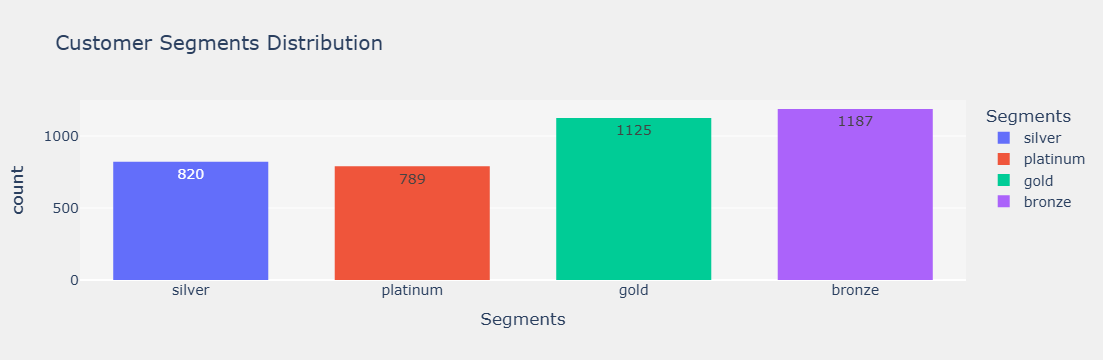

In [779]:
fig = px.histogram(
    data_frame=rfm,
    x='Segments',
    text_auto=True,
    color='Segments',
    title='Customer Segments Distribution',
)

fig.update_layout(
    plot_bgcolor='rgba(245, 245, 245, 1)',
    paper_bgcolor='rgba(240, 240, 240, 1)',
    font=dict(size=14),
    title_font=dict(size=20),
    bargap=0.3
)

fig.show()


## By using Clustering Techniques we can group the customers using Unsupervised learning

## Kmeans

In [782]:
kdf = rfm[['Recency',	'Frequency',	'Montery']]

In [876]:
wcss , score = []  , [] 
for k in range(3 , 25):
    model = make_pipeline(StandardScaler() ,KMeans(n_clusters=k))
    y = model.fit_predict(kdf)
    wcss.append(model.named_steps['kmeans'].inertia_)
    score.append(silhouette_score(kdf , y))

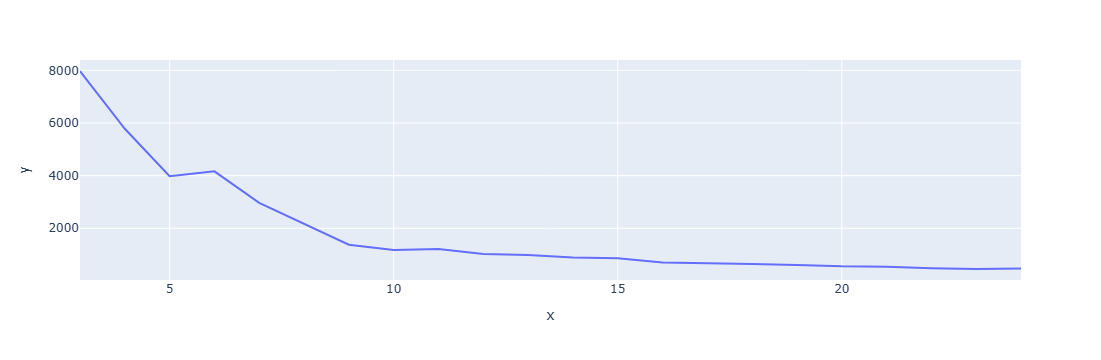

In [878]:
px.line(x = range(3 , 25) , y = wcss)

In [880]:
KneeLocator(range(3 , 25) , y = wcss , curve='convex' , direction = 'decreasing').elbow

5

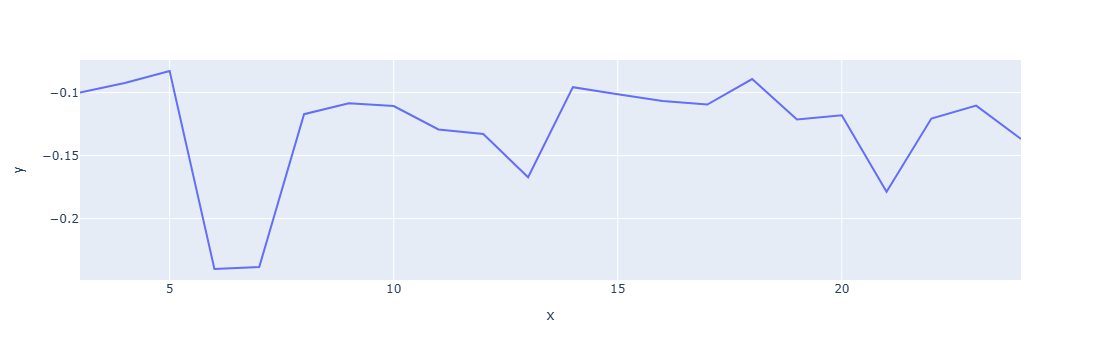

In [882]:
px.line(x = range(3 , 25) , y = score)

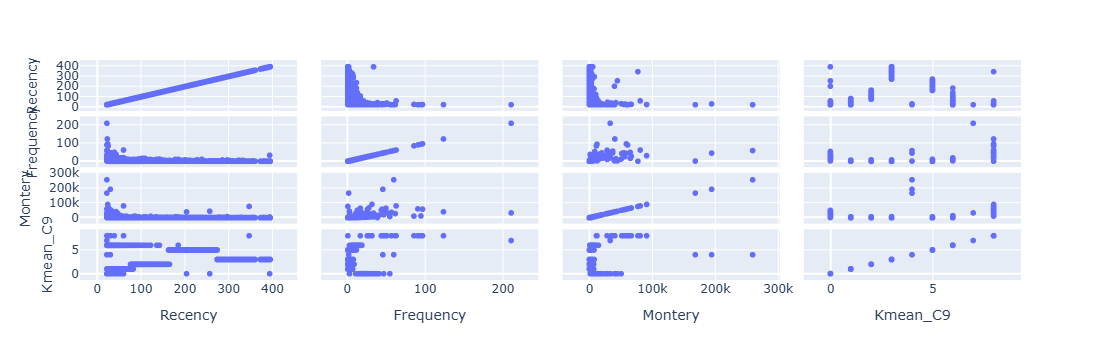

In [884]:
px.scatter_matrix(data_frame=kdf)

In [886]:
kdf

,Recency,Frequency,Montery,Kmean_C9
0,347,1,77183.60,8
1,24,11,4196.01,6
2,22,211,33053.19,7
3,25,5,4090.88,1
4,25,4,942.34,1
...,...,...,...,...
3916,299,1,180.60,3
3917,202,1,80.82,5
3918,29,2,178.05,1
3919,25,16,2045.53,6


In [934]:
kmeans = make_pipeline(StandardScaler() , KMeans(n_clusters=5))
kdf.loc[:,'Kmean_C9'] = kmeans.fit_predict(kdf)

In [936]:
pca = PCA(n_components=2)
tmp = pd.DataFrame(pca.fit_transform(kdf) , columns=['comp1' , 'comp2'])

In [938]:
tmp['cluster'] = kdf['Kmean_C9']

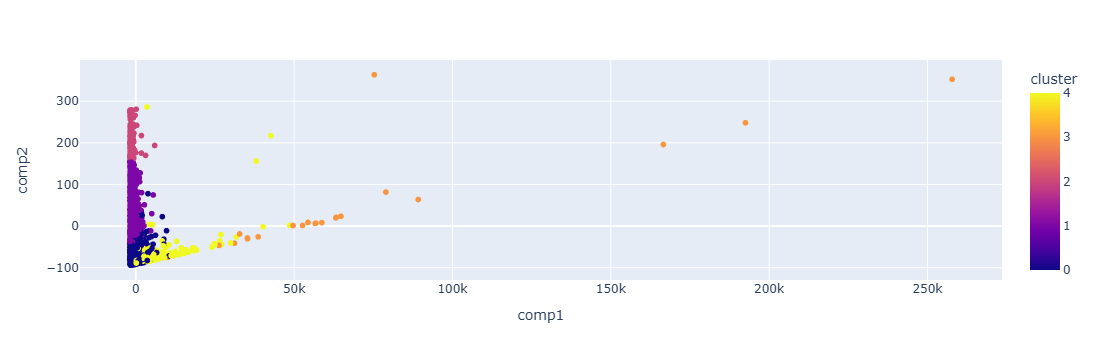

In [940]:
px.scatter(data_frame=tmp , x = 'comp1' , y = 'comp2' , color='cluster')

## Agglomerative Hierarchical

In [897]:
adf = rfm[['Recency',	'Frequency',	'Montery']]

In [899]:
score = []
for k in range(3 , 25):
    model = make_pipeline(StandardScaler() , AgglomerativeClustering(n_clusters=k))
    y = model.fit_predict(adf)
    score.append(silhouette_score(adf , y))    

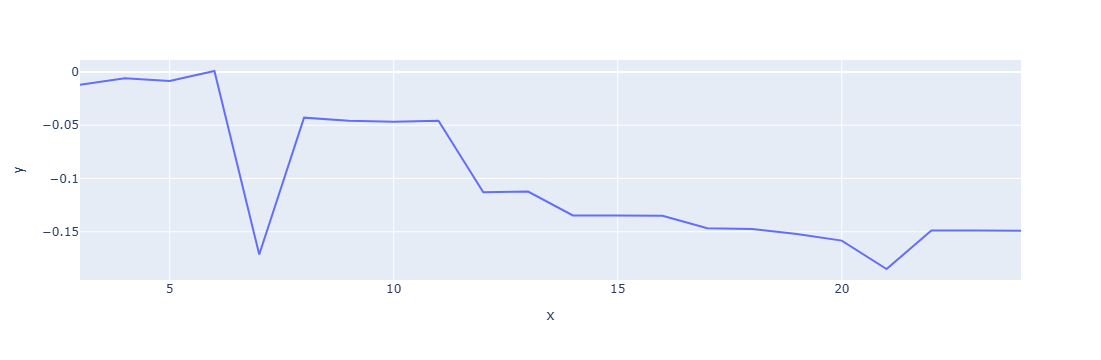

In [900]:
px.line(x = range(3 ,25) , y = score)

In [905]:
Ag = make_pipeline(StandardScaler() , AgglomerativeClustering(n_clusters=6))
adf.loc[:,'AGC_C6'] = Ag.fit_predict(adf)

In [907]:
pca = PCA(n_components=2)
tmp1 = pd.DataFrame(pca.fit_transform(adf) , columns=['comp1' , 'comp2'])

In [909]:
tmp1['cluster'] = adf['AGC_C6']

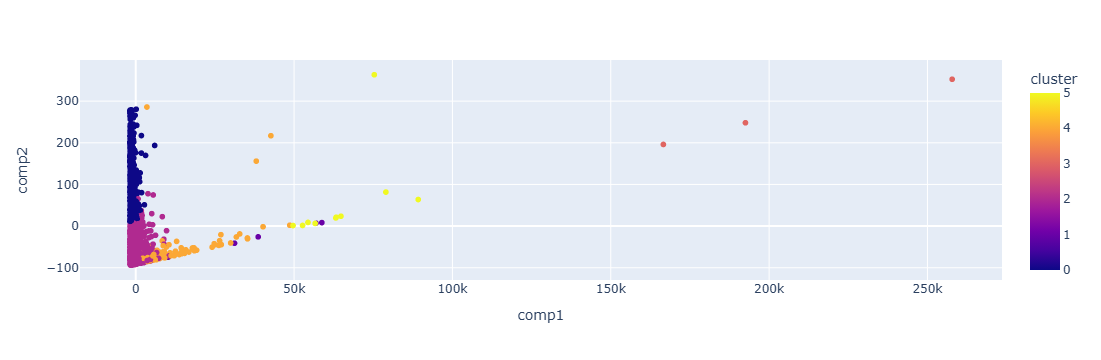

In [911]:
px.scatter(data_frame=tmp1 , x = 'comp1' , y = 'comp2' , color='cluster')

## DBSCAN

In [914]:
ddf = rfm[['Recency',	'Frequency',	'Montery']]

In [916]:
pca = PCA(n_components=2)
tmp2 = pd.DataFrame(pca.fit_transform(ddf) , columns=['comp1' , 'comp2'])

In [918]:
ds = DBSCAN(eps=4 , min_samples=10)
tmp2['Cluster'] = model.fit_predict(tmp2)

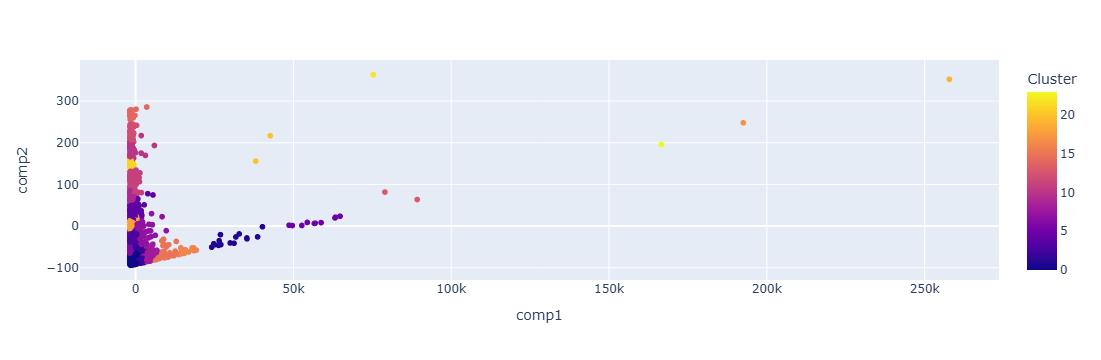

In [920]:
px.scatter(data_frame=tmp2 , x = 'comp1' , y = 'comp2' , color = 'Cluster')

### 🧠 Model Evaluation Summary

After evaluating multiple clustering models, **KMeans** proved to be the most effective for our dataset.

- It formed **5 clear and well-separated clusters**.
- The results were visualized using **PCA**, and the cluster distribution appeared compact and meaningful.
- Compared to other models, KMeans provided better interpretability and consistency.

📌 **Conclusion:**  
KMeans is selected as the best-performing clustering model for this analysis, with `n_clusters=5`.


#### 📎 Integration with Main Data

The resulting cluster assignments have been **added back to the main dataset** as a new column named `cluster`. This enables further analysis by cluster, including:

- Understanding characteristics of each group.
- Comparing distributions and patterns across clusters.
- Visualizing clusters using PCA for dimensionality reduction.

This enriched dataset will now be used for deeper insights and visual analytics.

In [944]:
rfm['Kmean_Cluster'] = kdf['Kmean_C9']

In [946]:
rfm

,CustomerID,Recency,Frequency,Montery,r_score,f_score,m_score,score,Segments,Kmean_Cluster
0,12346.0,347,1,77183.60,1,1,4,2.000000,silver,3
1,12747.0,24,11,4196.01,4,4,4,4.000000,platinum,0
2,12748.0,22,211,33053.19,4,4,4,4.000000,platinum,3
3,12749.0,25,5,4090.88,4,3,4,3.666667,platinum,0
4,12820.0,25,4,942.34,4,3,3,3.333333,gold,0
...,...,...,...,...,...,...,...,...,...,...
3916,18280.0,299,1,180.60,1,2,1,1.333333,bronze,2
3917,18281.0,202,1,80.82,1,2,1,1.333333,bronze,1
3918,18282.0,29,2,178.05,4,3,1,2.666667,gold,0
3919,18283.0,25,16,2045.53,4,4,4,4.000000,platinum,4


In [950]:
cluster_profile = rfm.groupby(['Kmean_Cluster'])[['Recency','Frequency','Montery','r_score','f_score','m_score']].mean()
display(cluster_profile)

,Recency,Frequency,Montery,r_score,f_score,m_score
Kmean_Cluster,,,,,,
0,46.018770,4.143900,1401.451575,3.340980,2.875391,2.793014
1,153.105302,2.091113,692.890846,1.599701,2.047797,2.134429
2,329.719178,1.287671,371.298151,1.000000,1.477169,1.559361
3,40.782609,60.130435,71418.253478,3.826087,3.782609,4.000000
4,35.852217,19.610837,9182.321478,3.763547,3.990148,3.995074


In [954]:
rfm['Kmean_Cluster'].value_counts().sort_index()

Kmean_Cluster
0    1918
1    1339
2     438
3      23
4     203
Name: count, dtype: int64

In [969]:
label_map = {
    0: 'Loyal',
    1: 'New',
    2: 'At Risk',
    3: 'Churned',
    4: 'Potential'
}
rfm['Cluster_Label'] = rfm['Kmean_Cluster'].map(label_map)

In [977]:
rfm['Cluster_Label'].value_counts()

Cluster_Label
Loyal        1918
New          1339
At Risk       438
Potential     203
Churned        23
Name: count, dtype: int64

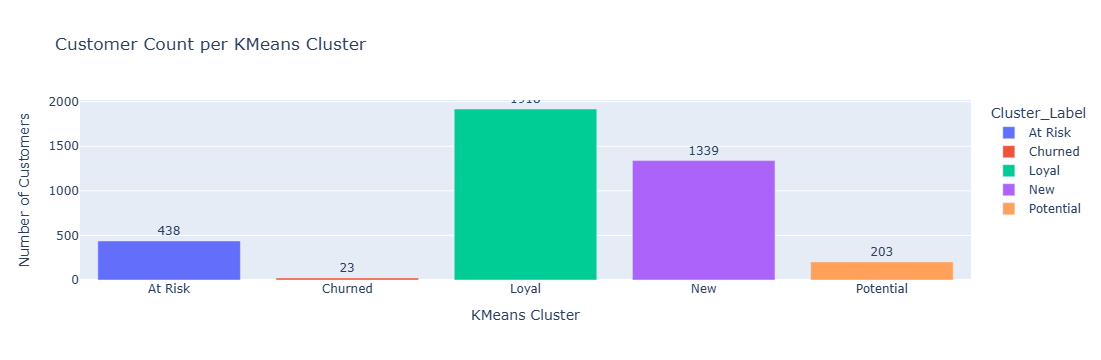

In [981]:
cluster_counts = rfm['Cluster_Label'].value_counts().sort_index().reset_index()
cluster_counts.columns = ['Cluster_Label', 'Count']

fig = px.bar(
    cluster_counts,
    x='Cluster_Label',
    y='Count',
    color='Cluster_Label',
    text='Count',
    text_auto=True,
    title='Customer Count per KMeans Cluster',
    color_continuous_scale='Viridis'
)

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_title='KMeans Cluster', yaxis_title='Number of Customers')
fig.show()

## DONE